In [1]:
using POMDPs, POMDPGym, Crux, Distributions, BSON, GridInterpolations, LinearAlgebra
using BSON: @save
using StatsFuns
using Random
using PGFPlots
using Colors, ColorSchemes

┌ Warning: You are using Matplotlib 3.3.4, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots /home/smkatz/.julia/packages/Plots/1KWPG/src/backends/pyplot.jl:29


In [2]:
resetPGFPlotsPreamble()
include("/home/smkatz/Documents/Util/support_code.jl");

In [3]:
include("../../src/multilevel_estimation.jl")
include("../../src/montecarlo.jl")
include("../../src/gaussian_process.jl")
include("../../src/bandit.jl")
include("../../src/kernel_bandit.jl")
include("../../src/learning_bandit.jl")
include("../../src/pspec_bandit.jl")
include("controller.jl")
include("setup.jl")

pendulum_problem (generic function with 1 method)

# Load in Ground Truth

In [4]:
function pendulum_mc_model(nθ, nω, nsamps; σθ_max=0.3, σω_max=0.3)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return MonteCarloModel(grid, nsamps)
end

pendulum_mc_model (generic function with 1 method)

In [5]:
model_gt = BSON.load("results/ground_truth.bson")[:model]
# Fix for bug when ground truth was generated
model_gt.β = model_gt.nsamps .+ model_gt.β .- 1
problem_gt = pendulum_problem(101, 101, σθ_max=0.2, σω_max=1.0, conf_threshold=0.95)
estimate_from_pfail!(problem_gt, model_gt)

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

model_gt_small = pendulum_mc_model(nθ, nω, 10000; σθ_max=σθ_max, σω_max=σω_max)

function fill_in_small(model_gt, model_gt_small)
    for ind in 1:length(model_gt_small.grid)
        x = ind2x(model_gt_small.grid, ind)
        ind_orig = interpolants(model_gt.grid, x)[1][1]
        model_gt_small.α[ind] = model_gt.α[ind_orig]
        model_gt_small.β[ind] = model_gt.β[ind_orig]
        model_gt_small.pfail[ind] = model_gt.pfail[ind_orig]
    end
end

fill_in_small(model_gt, model_gt_small)
problem_gt_small = pendulum_problem(nθ, nω, σθ_max=0.2, σω_max=1.0, conf_threshold=0.95)
estimate_from_pfail!(problem_gt_small, model_gt_small)

# Smoothing DKWUCB

In [6]:
wsqe_kernel(r, W; ℓ=0.01) = exp(-(r' * W * r) / (2 * ℓ^2))

function pendulum_kernel_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0, ℓ=2e-2, w=[1.0, 0.04])
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)

    return KernelBanditModel(grid, k, ℓ)
end

pendulum_kernel_bandit_model (generic function with 1 method)

In [49]:
model_k = pendulum_kernel_bandit_model(nθ, nω, ℓ=2e-2)
kernel_dkwucb_acquisition(model) = kernel_dkwucb_acquisition(model, problem.pfail_threshold,
                                                             problem.conf_threshold, rand_argmax=true, buffer=0.0)
run_estimation!(model_k, problem, kernel_dkwucb_acquisition, 100, tuple_return=true)

0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
26.0%┣███████████▏                               ┫ 26/100 [00:00<00:00, 191it/s]
59.0%┣█████████████████████████▍                 ┫ 59/100 [00:00<00:00, 319it/s]
89.0%┣██████████████████████████████████████▎    ┫ 89/100 [00:00<00:00, 379it/s]
100.0%┣█████████████████████████████████████████┫ 100/100 [00:00<00:00, 396it/s]


101-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 (0, 0)
 ⋮
 (0, 15)
 (0, 16)
 (0, 17)
 (0, 17)
 (0, 18)
 (0, 18)
 (0, 18)
 (0, 18)
 (0, 19)

In [55]:
αₖ = 1 .+ model_k.K * (model_k.α .- 1)
βₖ = 1 .+ model_k.K * (model_k.β .- 1)

test_stats = [quantile(Beta(α, β), 0.95) for (α, β) in zip(αₖ, βₖ)]

function get_test_stats(x, y, model)
    w = [1.0, 0.04]
    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=model.ℓ)
    K = [k([x, y], pt) for pt in model.grid]
    αₖ = 1 .+ K' * (model.α .- 1)
    βₖ = 1 .+ K' * (model.β .- 1)
    return quantile(Beta(αₖ, βₖ), 0.95)
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax1 = Axis(Plots.Image((x, y) -> get_test_stats(x, y, model_k), (0.0, 0.2), (0.0, 1.0),
    (colormap = pasteljet), colorbar=false, zmin=0.0, zmax=1.0))
ax2 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_k), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))

ax1.xlabel = L"$\sigma_\theta$"
ax1.ylabel = L"$\sigma_\omega$"
ax1.title = "Test Statistic"
ax1.width = "4cm"
ax1.height = "4cm"

ax2.xlabel = L"$\sigma_\theta$"
ax2.ylabel = L"$\sigma_\omega$"
ax2.title = "Safe Set"
ax2.width = "4cm"
ax2.height = "4cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
PGFPlots.save("temp.tex", g)
# g

In [56]:
run_estimation!(model_k, problem, kernel_dkwucb_acquisition, 400, tuple_return=true)

0.0%┣                                             ┫ 0/400 [00:00<00:-20, -0s/it]
0.2%┣                                          ┫ 1/400 [00:00<Inf:Inf, InfGs/it]
7.0%┣███                                         ┫ 28/400 [00:00<00:01, 260it/s]
14.0%┣██████                                     ┫ 56/400 [00:00<00:01, 356it/s]
21.0%┣█████████                                  ┫ 84/400 [00:00<00:01, 402it/s]
23.5%┣██████████                                 ┫ 94/400 [00:00<00:01, 362it/s]
29.0%┣████████████▏                             ┫ 116/400 [00:00<00:01, 329it/s]
32.8%┣█████████████▊                            ┫ 131/400 [00:00<00:01, 324it/s]
39.5%┣████████████████▋                         ┫ 158/400 [00:00<00:01, 347it/s]
46.5%┣███████████████████▌                      ┫ 186/400 [00:01<00:01, 368it/s]
53.5%┣██████████████████████▌                   ┫ 214/400 [00:01<00:00, 384it/s]
60.5%┣█████████████████████████▍                ┫ 242/400 [00:01<00:00, 398it/s]
67.5%┣██████████████████████

401-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (0, 19)
 (0, 19)
 (0, 20)
 (0, 21)
 (0, 21)
 (0, 21)
 (0, 21)
 (0, 22)
 (0, 22)
 ⋮
 (0, 92)
 (0, 92)
 (0, 92)
 (0, 92)
 (0, 92)
 (0, 92)
 (0, 92)
 (0, 93)
 (0, 93)

In [57]:
αₖ = 1 .+ model_k.K * (model_k.α .- 1)
βₖ = 1 .+ model_k.K * (model_k.β .- 1)

test_stats = [quantile(Beta(α, β), 0.95) for (α, β) in zip(αₖ, βₖ)]

function get_test_stats(x, y, model)
    w = [1.0, 0.04]
    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=model.ℓ)
    K = [k([x, y], pt) for pt in model.grid]
    αₖ = 1 .+ K' * (model.α .- 1)
    βₖ = 1 .+ K' * (model.β .- 1)
    return quantile(Beta(αₖ, βₖ), 0.95)
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax3 = Axis(Plots.Image((x, y) -> get_test_stats(x, y, model_k), (0.0, 0.2), (0.0, 1.0),
    (colormap = pasteljet), colorbar=false, zmin=0.0, zmax=1.0))
ax4 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_k), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))

ax3.xlabel = L"$\sigma_\theta$"
ax3.ylabel = L"$\sigma_\omega$"
ax3.title = "Test Statistic"
ax3.width = "4cm"
ax3.height = "4cm"

ax4.xlabel = L"$\sigma_\theta$"
ax4.ylabel = L"$\sigma_\omega$"
ax4.title = "Safe Set"
ax4.width = "4cm"
ax4.height = "4cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax3)
push!(g, ax4)
PGFPlots.save("temp.tex", g)
# g

In [58]:
run_estimation!(model_k, problem, kernel_dkwucb_acquisition, 1500, tuple_return=true)

0.0%┣                                            ┫ 0/1.5k [00:00<-1:-15, -0s/it]
0.1%┣                                         ┫ 1/1.5k [00:00<Inf:Inf, InfGs/it]
1.8%┣▊                                          ┫ 27/1.5k [00:00<00:06, 251it/s]
3.5%┣█▌                                         ┫ 52/1.5k [00:00<00:04, 331it/s]
5.2%┣██▎                                        ┫ 78/1.5k [00:00<00:04, 375it/s]
7.0%┣███                                       ┫ 105/1.5k [00:00<00:03, 405it/s]
8.2%┣███▍                                      ┫ 123/1.5k [00:00<00:04, 390it/s]
8.9%┣███▊                                      ┫ 133/1.5k [00:00<00:04, 362it/s]
10.1%┣████▏                                    ┫ 152/1.5k [00:00<00:04, 363it/s]
11.9%┣████▉                                    ┫ 178/1.5k [00:00<00:03, 380it/s]
12.6%┣█████▏                                   ┫ 189/1.5k [00:01<00:04, 353it/s]
14.4%┣██████                                   ┫ 216/1.5k [00:01<00:03, 369it/s]
16.2%┣██████▋               

1501-element Vector{Tuple{Int64, Int64}}:
 (0, 0)
 (0, 94)
 (0, 94)
 (0, 94)
 (0, 95)
 (0, 95)
 (0, 95)
 (0, 95)
 (0, 95)
 (0, 96)
 ⋮
 (2, 104)
 (2, 104)
 (2, 104)
 (2, 105)
 (2, 105)
 (2, 105)
 (2, 105)
 (2, 105)
 (2, 105)

In [59]:
αₖ = 1 .+ model_k.K * (model_k.α .- 1)
βₖ = 1 .+ model_k.K * (model_k.β .- 1)

test_stats = [quantile(Beta(α, β), 0.95) for (α, β) in zip(αₖ, βₖ)]

function get_test_stats(x, y, model)
    w = [1.0, 0.04]
    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=model.ℓ)
    K = [k([x, y], pt) for pt in model.grid]
    αₖ = 1 .+ K' * (model.α .- 1)
    βₖ = 1 .+ K' * (model.β .- 1)
    return quantile(Beta(αₖ, βₖ), 0.95)
end

black = RGB(0.0, 0.0, 0.0)
white = RGB(1.0, 1.0, 1.0)
green = RGB(20.0 / 255.0, 181.0 / 255.0, 127.0 / 255.0)
dark_green = RGB(0.5 * 20.0 / 255.0, 0.5 * 181.0 / 255.0, 0.5 * 127.0 / 255.0)
pastel_red = RGB(245.0 / 255.0, 97.0 / 255.0, 92.0 / 255.0)
the_colors = [green, dark_green, white, pastel_red]
safe_map = ColorMaps.RGBArrayMap(the_colors)

is_safe = test_stats .< 0.1
colors = ones(length(is_safe))
FN_inds = findall(.!is_safe .& problem_gt_small.is_safe)
!isnothing(FN_inds) ? colors[FN_inds] .= 2.0 : nothing
TN_inds = findall(.!is_safe .& .!problem_gt_small.is_safe)
!isnothing(TN_inds) ? colors[TN_inds] .= 3.0 : nothing
FP_inds = findall(is_safe .& .!problem_gt_small.is_safe)
!isnothing(FP_inds) ? colors[FP_inds] .= 4.0 : nothing

function get_heat_safe(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return colors[sps[argmax(ps)]]
end

ax5 = Axis(Plots.Image((x, y) -> get_test_stats(x, y, model_k), (0.0, 0.2), (0.0, 1.0),
    (colormap = pasteljet), colorbar=false, zmin=0.0, zmax=1.0))
ax6 = Axis(Plots.Image((x, y) -> get_heat_safe(x, y, model_k), (0.0, 0.2), (0.0, 1.0),
    (colormap = safe_map), colorbar=false, zmin=1.0, zmax=4.0))

ax5.xlabel = L"$\sigma_\theta$"
ax5.ylabel = L"$\sigma_\omega$"
ax5.title = "Test Statistic"
ax5.width = "4cm"
ax5.height = "4cm"

ax6.xlabel = L"$\sigma_\theta$"
ax6.ylabel = L"$\sigma_\omega$"
ax6.title = "Safe Set"
ax6.width = "4cm"
ax6.height = "4cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax5)
push!(g, ax6)
PGFPlots.save("temp.tex", g)
# g

# Kernel Learing Figures

In [60]:
# Load in previous results
ss1 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run1.bson")[:set_sizes_kkb]
model1 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run1.bson")[:model_kkb];

In [155]:
function get_heat(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    ind = sps[argmax(ps)]
    return dot(model.ℓs, model.curr_pspecℓs[ind, :])
end

function get_heat_2(x, y, model)
    sps, ps = interpolants(model.grid, [x, y])
    return model.pfail[sps[argmax(ps)]]
end

ax1 = Axis(Plots.Image((x, y) -> get_heat(x, y, model1), (0.0, 0.2), (0.0, 1.0),
    (colormap = pasteljet), colorbar=true, zmin=minimum(model1.ℓs), zmax=maximum(model1.ℓs)))

ax1.xlabel = L"$\sigma_\theta$"
ax1.ylabel = L"$\sigma_\omega$"
ax1.title = L"$E[\ell]$"
ax1.width = "6cm"
ax1.height = "6cm"

ax2 = Axis(Plots.Image((x, y) -> get_heat_2(x, y, model_gt_small), (0.0, 0.2), (0.0, 1.0),
    (colormap = pasteljet), colorbar=true, zmin=0.0, zmax=1.0))

ax2.xlabel = L"$\sigma_\theta$"
ax2.ylabel = L"$\sigma_\omega$"
ax2.title = L"$\hat P_\text{fail}(\eta)$"
ax2.width = "6cm"
ax2.height = "6cm"

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
PGFPlots.save("l_expectation.tex", g, include_preamble=false)
# g

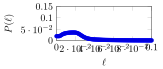

In [148]:
function plot_ℓdist(point, model)
    sps, ps = interpolants(model.grid, point)
    ind = sps[argmax(ps)]
    ax = Axis(Plots.Linear(model.ℓs, model.curr_pspecℓs[ind, :]))
    ax.xlabel = L"$\ell$"
    ax.ylabel = L"$P(\ell)$"
    ax.height = "2.8cm"
    ax.width = "5cm"
    ax.xmin = 0.0
    ax.xmax = 0.1
    ax.ymin = 0.0
    ax.ymax = 0.15
    return ax
end

ax1 = plot_ℓdist([0.02, 0.1], model1)

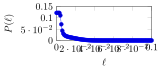

In [149]:
ax2 = plot_ℓdist([0.075, 0.4], model1)

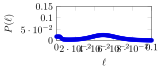

In [150]:
ax3 = plot_ℓdist([0.08, 0.4], model1)

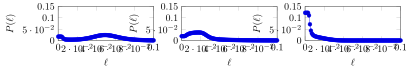

In [152]:
g = GroupPlot(3, 1, groupStyle="horizontal sep = 1cm, vertical sep = 1.5cm")
push!(g, ax3)
push!(g, ax1)
push!(g, ax2)
PGFPlots.save("ldists.tex", g, include_preamble=false)
g

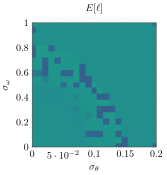

In [109]:
function plot_Eℓ(model, iter)
    #### Get current counts ####
    eval_inds = model.eval_inds[1:iter]
    eval_res = model.eval_res[1:iter]

    αs = zeros(length(model.grid))
    βs = zeros(length(model.grid))
    for i = 1:length(model.grid)
        eval_inds_inds = findall(eval_inds .== i)
        neval = length(eval_inds_inds)
        if neval > 0
            αs[i] = 1 + sum(eval_res[eval_inds_inds])
            βs[i] = 2 + neval - αs[i]
        else
            αs[i] = 1
            βs[i] = 1
        end
    end
    ############################

    #### Get current estimates ####
    αₖ = reshape(1 .+ model.Ks * (αs .- 1), length(model.grid), length(model.ℓs))
    βₖ = reshape(1 .+ model.Ks * (βs .- 1), length(model.grid), length(model.ℓs))
    pspec_pℓs = pspec_pℓ(αs, βs, αₖ, βₖ)
    ##############################

    function get_heat(x, y, model)
        sps, ps = interpolants(model.grid, [x, y])
        ind = sps[argmax(ps)]
        return dot(model.ℓs, pspec_pℓs[ind, :])
    end

    ax = Axis(Plots.Image((x, y) -> get_heat(x, y, model1), (0.0, 0.2), (0.0, 1.0),
        (colormap = pasteljet), colorbar=false, zmin=minimum(model.ℓs), zmax=maximum(model.ℓs)))

    ax.xlabel = L"$\sigma_\theta$"
    ax.ylabel = L"$\sigma_\omega$"
    ax.title = L"$E[\ell]$"
    ax.width = "6cm"
    ax.height = "6cm"
    return ax
end

ax = plot_Eℓ(model1, 500)

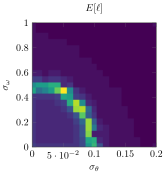

In [113]:
function plot_total_counts(model, iter)
    #### Get current counts ####
    eval_inds = model.eval_inds[1:iter]
    eval_res = model.eval_res[1:iter]

    αs = zeros(length(model.grid))
    βs = zeros(length(model.grid))
    for i = 1:length(model.grid)
        eval_inds_inds = findall(eval_inds .== i)
        neval = length(eval_inds_inds)
        if neval > 0
            αs[i] = 1 + sum(eval_res[eval_inds_inds])
            βs[i] = 2 + neval - αs[i]
        else
            αs[i] = 1
            βs[i] = 1
        end
    end
    ############################

    function get_heat(x, y, model)
        sps, ps = interpolants(model.grid, [x, y])
        ind = sps[argmax(ps)]
        return αs[ind] + βs[ind]
    end

    ax = Axis(Plots.Image((x, y) -> get_heat(x, y, model1), (0.0, 0.2), (0.0, 1.0),
        (colormap = pasteljet), colorbar=false))

    ax.xlabel = L"$\sigma_\theta$"
    ax.ylabel = L"$\sigma_\omega$"
    ax.title = L"$E[\ell]$"
    ax.width = "6cm"
    ax.height = "6cm"
    return ax
end

ax = plot_total_counts(model1, 1000)

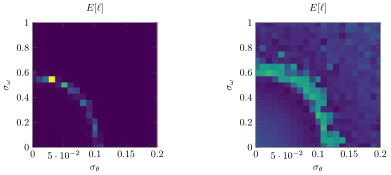

In [119]:
iter = 50000

ax1 = plot_total_counts(model1, iter)
ax2 = plot_Eℓ(model1, iter)

g = GroupPlot(2, 1, groupStyle="horizontal sep = 3.5cm, vertical sep = 1.5cm")
push!(g, ax1)
push!(g, ax2)
g